<a href="https://colab.research.google.com/github/durrapearl/mqtt/blob/main/Hybrid_Intrusion_detection_biflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from imblearn.over_sampling import ADASYN
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#extract zipfile
import zipfile

# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/drive/MyDrive/biflow_features.zip'
extraction_path = '/content/biflow_features/'

# Create the extraction directory if it doesn't exist
import os
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# List the extracted files
extracted_files = os.listdir(extraction_path)
print(f'Extracted files: {extracted_files}')

Mounted at /content/drive
Extracted files: ['biflow_scan_A.csv', 'biflow_sparta.csv', 'biflow_mqtt_bruteforce.csv', 'biflow_normal.csv', 'biflow_scan_sU.csv']


In [4]:
# Import the os module if not already imported
import os

# Define file paths for the CSV files
normal_csv_path = os.path.join(extraction_path, 'biflow_normal.csv')
scan_su_csv_path = os.path.join(extraction_path, 'biflow_scan_sU.csv')
sparta_csv_path = os.path.join(extraction_path, 'biflow_sparta.csv')
mqtt_bruteforce_csv_path = os.path.join(extraction_path, 'biflow_mqtt_bruteforce.csv')

# Load CSV files into DataFrames
normal_df = pd.read_csv(normal_csv_path)
scan_su_df = pd.read_csv(scan_su_csv_path)
sparta_df = pd.read_csv(sparta_csv_path)
mqtt_bruteforce_df = pd.read_csv(mqtt_bruteforce_csv_path)

# Add a 'class' column to each DataFrame
normal_df['class'] = 0
scan_su_df['class'] = 1
sparta_df['class'] = 2
mqtt_bruteforce_df['class'] = 3
# Concatenate the DataFrames into one combined_df
df = pd.concat([normal_df, scan_su_df, sparta_df, mqtt_bruteforce_df], ignore_index=True)

# Add a 'class' column to each DataFrame
normal_df['class'] = 'normal'
scan_su_df['class'] = 'scan_su'
sparta_df['class'] = 'sparta'
mqtt_bruteforce_df['class'] = 'mqtt_bruteforce'
# Concatenate the DataFrames into one combined_df
combined_df = pd.concat([normal_df, scan_su_df, sparta_df, mqtt_bruteforce_df], ignore_index=True)

In [5]:
# Check the distribution of labels
label_counts = combined_df['class'].value_counts()
print(label_counts)

sparta             91318
normal             86008
scan_su            39664
mqtt_bruteforce    16696
Name: class, dtype: int64


Label Distribution:
0    182592
1     51094
Name: is_attack, dtype: int64


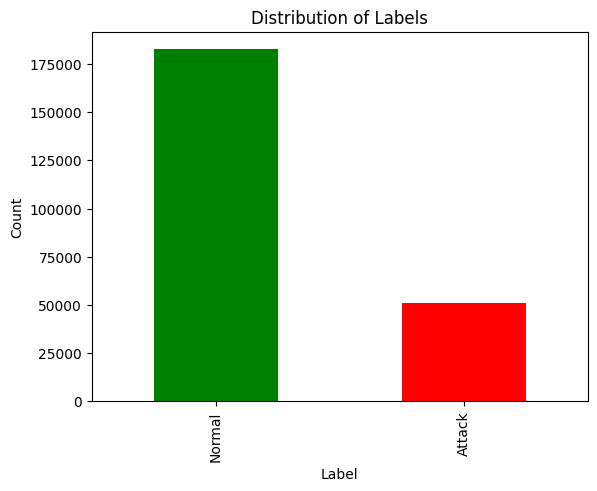

In [6]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset into a DataFrame (assuming you already have your dataset loaded)
# For example, if your dataset is named 'normal_df':
# normal_df = pd.read_csv(normal_csv_path)  # Load your dataset

# Assuming that the label column is named 'is_attack', you can check its distribution:
label_distribution = combined_df['is_attack'].value_counts()

# Print the distribution
print("Label Distribution:")
print(label_distribution)

# Create a bar plot to visualize the distribution
label_distribution.plot(kind='bar', color=['green', 'red'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.show()

In [7]:
# Extract the features (X) and labels (y)
y = df['class']  # 'class' column is your label
X = df.drop(columns=['class'])  # Exclude the 'class' column from features
labels = y.unique()

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print("after splitting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))

(233686, 32)
number of labels: 4
instances per label
 2    91318
0    86008
1    39664
3    16696
Name: class, dtype: int64
labels: [0 1 2 3]
after splitting the data:

training data length: 175264
test data length: 58422


In [8]:
# Label encoding for XGBClassifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
from collections import Counter
class_distribution = Counter(y_train)
print(class_distribution)

Counter({2: 68488, 0: 64506, 1: 29748, 3: 12522})


In [10]:
df

,ip_src,ip_dst,prt_src,prt_dst,proto,fwd_num_pkts,bwd_num_pkts,fwd_mean_iat,bwd_mean_iat,fwd_std_iat,...,fwd_num_bytes,bwd_num_bytes,fwd_num_psh_flags,bwd_num_psh_flags,fwd_num_rst_flags,bwd_num_rst_flags,fwd_num_urg_flags,bwd_num_urg_flags,is_attack,class
0,10.0.0.5,192.168.1.7,56572,1883,6,7,5,0.000237,0.000203,0.000218,...,444,272,3,1,0,0,0,0,0,0
1,10.0.0.11,192.168.1.7,51906,1883,6,7,5,0.000242,0.000243,0.000207,...,483,272,3,1,0,0,0,0,0,0
2,10.0.0.14,192.168.1.7,54202,1883,6,7,5,0.000284,0.000349,0.000323,...,531,272,3,1,0,0,0,0,0,0
3,10.0.0.12,192.168.1.7,39782,1883,6,7,5,0.001038,0.000968,0.000895,...,462,272,3,1,0,0,0,0,0,0
4,10.0.0.13,192.168.1.7,38052,1883,6,7,5,0.001039,0.000968,0.000776,...,463,272,3,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233681,192.168.2.7,8.8.8.8,51244,53,17,1,1,0.000000,0.000000,0.000000,...,76,76,0,0,0,0,0,0,0,3
233682,192.168.2.6,8.8.8.8,43401,53,17,4,4,1.668555,1.668555,2.359687,...,332,332,0,0,0,0,0,0,0,3
233683,192.168.2.7,8.8.8.8,38256,53,17,1,1,0.000000,0.000000,0.000000,...,91,91,0,0,0,0,0,0,0,3
233684,192.168.2.7,8.8.8.8,55306,53,17,1,1,0.000000,0.000000,0.000000,...,76,76,0,0,0,0,0,0,0,3


In [13]:
# Assuming 'ip_src' and 'ip_dst' are categorical columns in your original DataFrame
categorical_cols = ['ip_src', 'ip_dst']  # Add other categorical columns if needed
encoder = OneHotEncoder(sparse=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Normalize the numerical columns for X_train
numeric_cols = X_train.columns.difference(categorical_cols)
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])

# Apply ADASYN for oversampling
adasyn = ADASYN(n_jobs=-1, sampling_strategy={2: 68488, 0: 64506, 1: 29748, 3: 12522})
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_encoded, y_train_encoded)

# Normalize the numerical columns for X_test
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Combine the one-hot encoded categorical columns with the normalized numeric columns for both X_train and X_test
X_train_final = np.hstack((X_train_scaled_numeric, X_train_resampled))
X_test_final = np.hstack((X_test_scaled_numeric, X_test_encoded))

In [14]:
# Train the XGBoost algorithm
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_final, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:
# One-hot encode y_train and y_test for the neural network
y_train_encoded_nn = to_categorical(y_train_encoded)
y_test_encoded_nn = to_categorical(y_test_encoded)

In [20]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Define the neural network model with the correct input dimensions
num_classes = len(label_encoder.classes_)  # Number of unique classes
model = Sequential()
model.add(Dense(128, input_dim=X_train_final.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

# Define a learning rate schedule
initial_learning_rate = 0.00001

def lr_schedule(epoch):
    return initial_learning_rate * 0.95**epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with the Adam optimizer and the learning rate schedule
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_final, y_train_encoded_nn, batch_size=32, epochs=50, verbose=1, validation_data=(X_test_final, y_test_encoded_nn))

# Make predictions on test data using the neural network
predictions_nn = model.predict(X_test_final)

Epoch 1/50
5477/5477 [==============================] - 16s 3ms/step - loss: 0.3415 - accuracy: 0.8298 - val_loss: 0.2906 - val_accuracy: 0.8418
Epoch 2/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2793 - accuracy: 0.8440 - val_loss: 0.2774 - val_accuracy: 0.8488
Epoch 3/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2712 - accuracy: 0.8462 - val_loss: 0.2787 - val_accuracy: 0.8461
Epoch 4/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2625 - accuracy: 0.8530 - val_loss: 0.2798 - val_accuracy: 0.8405
Epoch 5/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2527 - accuracy: 0.8597 - val_loss: 0.2718 - val_accuracy: 0.8557
Epoch 6/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2416 - accuracy: 0.8688 - val_loss: 0.3163 - val_accuracy: 0.8814
Epoch 7/50
5477/5477 [==============================] - 15s 3ms/step - loss: 0.2277 - accuracy: 0.8787 - val_loss: 0.2987 - val_ac

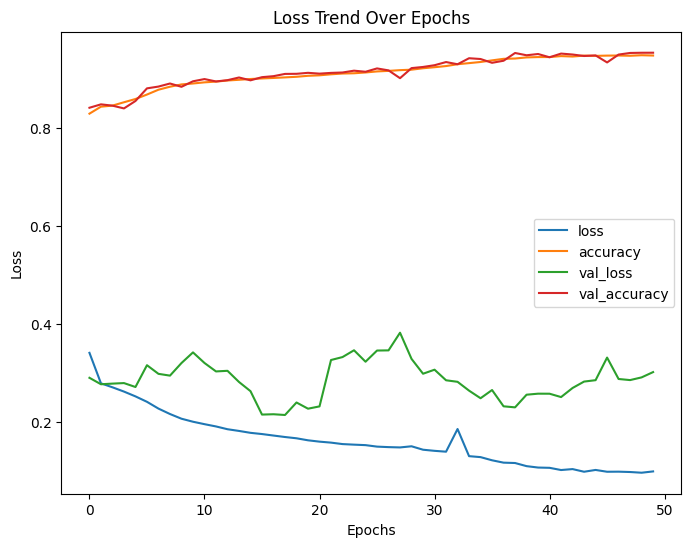

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to plot the loss trend
loss_df = pd.DataFrame(history.history)

# Plot the loss trend
loss_df.plot(kind='line', xlabel='Epochs', ylabel='Loss', title='Loss Trend Over Epochs', figsize=(8, 6))
plt.show()

In [22]:
# Make predictions on test data using the neural network
predictions_nn = model.predict(X_test_final)

# Convert predictions to class labels
y_pred_nn = label_encoder.inverse_transform(predictions_nn.argmax(axis=1))

# Split the data into training and test sets for the neural network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size=0.2, random_state=42)

1826/1826 [==============================] - 3s 2ms/step


In [23]:
# Make predictions on the test set using XGBoost
y_pred_xgb = xgb_model.predict(X_test_final)

# Ensure that y_test_nn is in the same order as predictions_nn
y_test_nn_encoded = label_encoder.transform(y_test_nn)

In [24]:
# Get the unique attack types
attack_types = df['class'].unique()
# Create a dictionary to map attack labels to attack types
label_to_attack = dict(zip(range(len(attack_types)), attack_types))
# Map the predicted labels to attack types
predicted_attacks_xgb = [label_to_attack[label] for label in y_pred_xgb]
# Map the true labels to attack types
true_attacks_xgb = [label_to_attack[label] for label in y_test_encoded]

Ensembled Model Metrics:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     21502
           1       0.99      0.94      0.96      9916
           2       0.97      0.96      0.97     22830
           3       1.00      1.00      1.00      4174

    accuracy                           0.96     58422
   macro avg       0.97      0.97      0.97     58422
weighted avg       0.96      0.96      0.96     58422

Accuracy of Ensembled Model: 0.9628393413440143
Precision of Ensembled Model: 0.9631681689894501
Recall of Ensembled Model: 0.9628393413440143
Average F1 of Ensembled Model: 0.9628868207422608
F1 of Ensembled Model for each type of attack: [0.95247078 0.96424892 0.96534187 0.9998802 ]


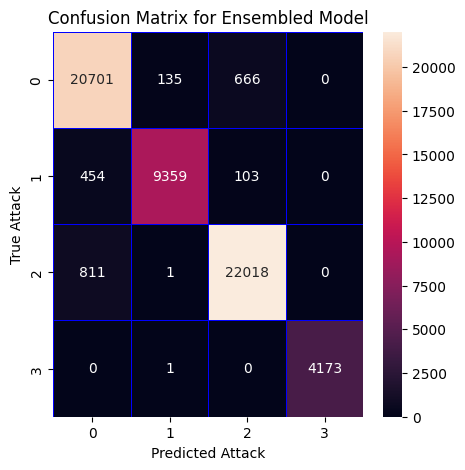

In [25]:
# Evaluate the performance of Ensembled Model
print("Ensembled Model Metrics:")
print(classification_report(y_test_encoded, y_pred_xgb))
print("Accuracy of Ensembled Model:", accuracy_score(y_test_encoded, y_pred_xgb))
print("Precision of Ensembled Model:", precision_score(y_test_encoded, y_pred_xgb, average='weighted'))
print("Recall of Ensembled Model:", recall_score(y_test_encoded, y_pred_xgb, average='weighted'))
print("Average F1 of Ensembled Model:", f1_score(y_test_encoded, y_pred_xgb, average='weighted'))
print("F1 of Ensembled Model for each type of attack:", f1_score(y_test_encoded, y_pred_xgb, average=None))

# Plot the confusion matrix for Ensembled Model
cm_xgb = confusion_matrix(true_attacks_xgb, predicted_attacks_xgb, labels=attack_types)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_xgb, annot=True, linewidth=0.5, linecolor="blue", fmt="d", ax=ax)
plt.xlabel("Predicted Attack")
plt.ylabel("True Attack")
plt.title("Confusion Matrix for Ensembled Model")
plt.show()